<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

def preprocess_and_train_model(matched_data):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    # Model Definition
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')  # Adjust output layer according to your needs
        ])
        return model

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)

    # Predictions and Evaluation
    predictions = model.predict(X_test).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y_test
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    r_squared = r2_score(inversed_truth, inversed_predictions)

    return model, test_loss, r_squared, inversed_predictions, scaler

# Use the function with your DataFrame
# model, test_loss, r_squared, predictions = preprocess_and_train_model(your_dataframe)


In [5]:
def predict_on_reserve(matched_data,model,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] =inversed_truth.flatten()
    return matched_data

In [6]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [7]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [8]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [9]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [10]:


# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [11]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


In [13]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


prediction_list = []

for i in range(10):
  matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, inversed_predictions, scaler = preprocess_and_train_model(matched_data)

  predictions = predict_on_reserve(reserve_data,model,scaler)
  prediction_list.append(predictions)


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 63ms/step - loss: 2.2943 - val_loss: 0.0211
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.3320 - val_loss: 0.0340
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 2.3167 - val_loss: 0.0389
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 2.4475 - val_loss: 0.0343
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6606 - val_loss: 0.0324
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.8341 - val_loss: 0.0335
Epoch 7/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3984 - val_loss: 0.0332
Epoch 8/100
5/5 [==============================] - 0s 16ms/step - loss: 1.0951 - val_loss: 0.0308
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3409 - val_loss: 0.0279
Epoch 10/100
5/5 [==============================] - 0s 16ms/step - loss: 1.4872 - val_loss: 0.0295
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 53ms/step - loss: 2.6261 - val_loss: 0.0639
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 3.2669 - val_loss: 0.0251
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 2.6824 - val_loss: 0.0401
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.8656 - val_loss: 0.0403
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.8850 - val_loss: 0.0370
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6847 - val_loss: 0.0434
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 2.1798 - val_loss: 0.0414
Epoch 8/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6728 - val_loss: 0.0429
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.1006 - val_loss: 0.0459
Epoch 10/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6332 - val_loss: 0.0445
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 54ms/step - loss: 2.0707 - val_loss: 0.0475
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2042 - val_loss: 0.0456
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.1856 - val_loss: 0.0248
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6496 - val_loss: 0.0295
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 1.9460 - val_loss: 0.0289
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.8468 - val_loss: 0.0323
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7362 - val_loss: 0.0388
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.5145 - val_loss: 0.0405
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.0420 - val_loss: 0.0408
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.0352 - val_loss: 0.0406
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 55ms/step - loss: 2.5221 - val_loss: 0.1038
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.3522 - val_loss: 0.0402
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.4120 - val_loss: 0.0552
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 2.2717 - val_loss: 0.0529
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7092 - val_loss: 0.0517
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 2.2409 - val_loss: 0.0523
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 2.5989 - val_loss: 0.0586
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7123 - val_loss: 0.0555
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.6641 - val_loss: 0.0526
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2380 - val_loss: 0.0504
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 53ms/step - loss: 3.9205 - val_loss: 0.0330
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 2.2526 - val_loss: 0.0305
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 2.1316 - val_loss: 0.0597
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 2.0104 - val_loss: 0.0433
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7715 - val_loss: 0.0328
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 2.0163 - val_loss: 0.0417
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7163 - val_loss: 0.0379
Epoch 8/100
5/5 [==============================] - 0s 16ms/step - loss: 1.2319 - val_loss: 0.0351
Epoch 9/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3243 - val_loss: 0.0339
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 0.9652 - val_loss: 0.0325
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 50ms/step - loss: 2.4686 - val_loss: 0.0209
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 2.0438 - val_loss: 0.0196
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9985 - val_loss: 0.0307
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.7811 - val_loss: 0.0301
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7705 - val_loss: 0.0309
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6042 - val_loss: 0.0293
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4190 - val_loss: 0.0344
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.5258 - val_loss: 0.0348
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.1882 - val_loss: 0.0352
Epoch 10/100
5/5 [==============================] - 0s 16ms/step - loss: 0.9446 - val_loss: 0.0375
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 53ms/step - loss: 2.2157 - val_loss: 0.0940
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2855 - val_loss: 0.0393
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.7516 - val_loss: 0.0489
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 2.1194 - val_loss: 0.0438
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7896 - val_loss: 0.0424
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.5485 - val_loss: 0.0410
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3450 - val_loss: 0.0404
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.0145 - val_loss: 0.0431
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6464 - val_loss: 0.0387
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.3763 - val_loss: 0.0385
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 56ms/step - loss: 2.2143 - val_loss: 0.0341
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.7077 - val_loss: 0.0204
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 3.4661 - val_loss: 0.0407
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2188 - val_loss: 0.0338
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5307 - val_loss: 0.0322
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.9441 - val_loss: 0.0363
Epoch 7/100
5/5 [==============================] - 0s 21ms/step - loss: 1.6311 - val_loss: 0.0322
Epoch 8/100
5/5 [==============================] - 0s 16ms/step - loss: 1.2362 - val_loss: 0.0282
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2008 - val_loss: 0.0312
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0636 - val_loss: 0.0311
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 1s 54ms/step - loss: 2.3955 - val_loss: 0.0285
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.0566 - val_loss: 0.0216
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 1.9783 - val_loss: 0.0222
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 2.2239 - val_loss: 0.0305
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 2.2711 - val_loss: 0.0281
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 2.3629 - val_loss: 0.0288
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.3462 - val_loss: 0.0301
Epoch 8/100
5/5 [==============================] - 0s 22ms/step - loss: 1.1877 - val_loss: 0.0315
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2738 - val_loss: 0.0323
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4249 - val_loss: 0.0357
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


5/5 [==============================] - 2s 58ms/step - loss: 2.6650 - val_loss: 0.0216
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.3238 - val_loss: 0.0496
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.3947 - val_loss: 0.0395
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 3.7826 - val_loss: 0.0388
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6927 - val_loss: 0.0350
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4591 - val_loss: 0.0396
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6922 - val_loss: 0.0395
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3092 - val_loss: 0.0395
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2387 - val_loss: 0.0442
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.0623 - val_loss: 0.0413
Epoch 11/100
5/5 [=============

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [14]:
combined_array = np.array([predictions['inversed_predictions'].values for predictions in prediction_list])

In [15]:
combined_array[combined_array < 0 ] = 0

In [16]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [18]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [22]:
# array = norm_dist_array[0]
# # Generating y values as indices (percentiles in this context)
# y_values = np.linspace(1, 100, len(array))

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(array, y_values, marker='o', linestyle='-', color='b')
# plt.title('Index (Percentile) by Value')
# plt.xlabel('Value')
# plt.ylabel('Percentile')
# plt.grid(True)
# plt.show()

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.hist(array, bins=len(array), edgecolor='black')
# plt.title('Histogram of Values')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()



In [23]:
pred_data = prediction_list[0]

In [24]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = pred_data.iloc[:,keep_cols]

scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['dist_array'] = dist_array

scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = pred_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


In [25]:
numeric_df.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'water',
       'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
       'built', 'bare', 'snow_and_ice', 'elevation', 'landform', 'SRTM_mTPI',
       'aet', 'pdsi', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn',
       'tmmx', 'vap', 'vpd', 'vs', 'agbd_m', 'norm_dist_array'],
      dtype='object')

In [26]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')  # Adjust output layer according to your needs
    ])
    return model


In [27]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

In [28]:
scaled_numeric_df.dropna(inplace=True)

In [29]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [30]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [32]:
y_train.shape

(580, 10)

In [33]:


# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)
# dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
# dummy_array[:, -1] = predictions
# inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
# dummy_array[:, -1] = y_test
# inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
# r_squared = r2_score(inversed_truth, inversed_predictions)

# return model, test_loss, r_squared, inversed_predictions, scaler

Epoch 1/600
4/4 [==============================] - 1s 73ms/step - loss: 2.1794 - mae: 1.1057 - val_loss: 0.0596 - val_mae: 0.2010
Epoch 2/600
4/4 [==============================] - 0s 20ms/step - loss: 1.9389 - mae: 1.0368 - val_loss: 0.0584 - val_mae: 0.1991
Epoch 3/600
4/4 [==============================] - 0s 19ms/step - loss: 1.7601 - mae: 0.9936 - val_loss: 0.0590 - val_mae: 0.2009
Epoch 4/600
4/4 [==============================] - 0s 19ms/step - loss: 1.7119 - mae: 0.9773 - val_loss: 0.0603 - val_mae: 0.2039
Epoch 5/600
4/4 [==============================] - 0s 19ms/step - loss: 1.6883 - mae: 0.9864 - val_loss: 0.0614 - val_mae: 0.2063
Epoch 6/600
4/4 [==============================] - 0s 21ms/step - loss: 1.6190 - mae: 0.9566 - val_loss: 0.0622 - val_mae: 0.2086
Epoch 7/600
4/4 [==============================] - 0s 19ms/step - loss: 1.6814 - mae: 0.9841 - val_loss: 0.0629 - val_mae: 0.2103
Epoch 8/600
4/4 [==============================] - 0s 20ms/step - loss: 1.5390 - mae: 0.93

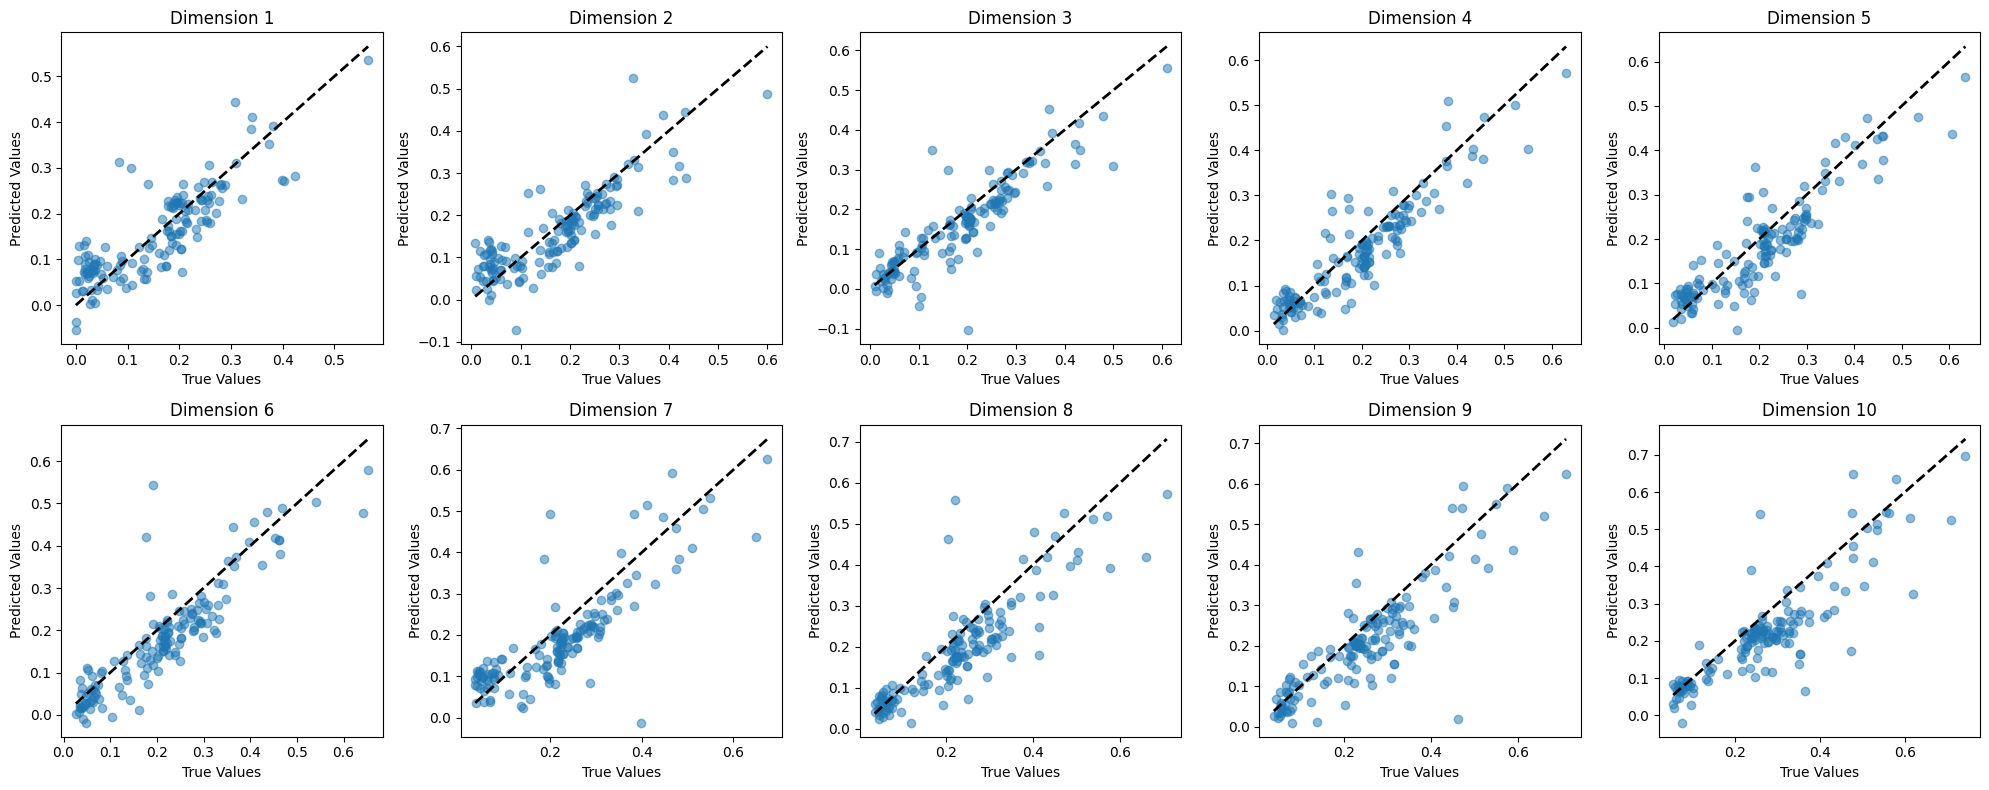

In [35]:
import matplotlib.pyplot as plt
# Example data
n_samples = y_test.shape[1]
n_outputs = y_test.shape[0]  # This should be 10 based on your output shape

# Assuming y_true and y_pred are already defined and properly shaped
n_dimensions = y_test.shape[1]  # Should be 10

# Create a figure and axes with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(n_dimensions):
    ax = axes[i // 5, i % 5]  # Determine the position of the subplot
    ax.scatter(y_test[:, i], predictions[:, i], alpha=0.5)
    ax.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)  # Line y=x
    ax.set_title(f'Dimension {i+1}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [ ]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])